In [1]:
# load dependencies
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import glob

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.densenet import decode_predictions
from tensorflow.keras.applications import densenet, inception_v3, mobilenet_v2
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model

from grad_cam import GradCAM

from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [8]:
def build_model():
    base_model = densenet.DenseNet121(input_shape=(224, 224, 3),
                      weights='imagenet',
                      include_top=False,
                      pooling='avg')
    x = base_model.output
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

def build_mobilenetv2():
    base_model = mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3),
                      weights='imagenet',
                      include_top=False,
                      pooling='avg')
    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [3]:
datasetfolder = './data/test1/'
dataset_train = datasetfolder + 'train/'
dataset_val = datasetfolder + 'val/'

In [4]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_it = datagen.flow_from_directory(datasetfolder + 'train/',
    class_mode='categorical', batch_size=30, target_size=(224, 224))
test_it = datagen.flow_from_directory(datasetfolder + 'val/',
    class_mode='categorical', batch_size=30, target_size=(224, 224))

n_classes = train_it.num_classes
n_classes

Found 34 images belonging to 2 classes.
Found 29 images belonging to 2 classes.


2

In [5]:
model = build_model()
model.load_weights('./models/covid19_densenet_04_1.00.hdf5')

In [19]:
# model.summary()

In [6]:
def predict(mdl, path):
    img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img *(1./255.)
    
    # make model predictions
    predictions = mdl.predict(np.array([img]))
    return(np.argmax(predictions))

def validate_class(mdl, path, cls):
    x = []
    y = []
    o = []
    files = glob.glob(path + '/*')
    odds = {}
    for file in files:
        pred = predict(mdl, file)
        x.append(pred)
        y.append(clss_dict[cls])
        if pred != clss_dict[cls]:
            o.append((file, pred))
            if pred in odds.keys():
                odds[pred].append(file)
            else:
                odds[pred] = [file] 
    cr = classification_report(y, x)
    return o, odds, cr

class 0 => covid - 52.30%


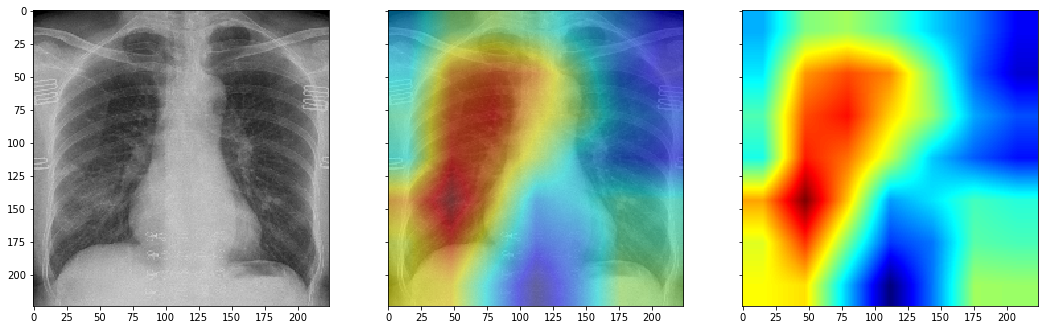

In [7]:
name = 'ryct.2020200028.fig1a'
img_path = './data/test1/val/covid/' + name + '.jpeg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img *(1./255.)

# view the image
# plt.imshow(img)

# make model predictions
predictions = model.predict(np.array([img]))
c = np.argmax(predictions)
label = list(train_it.class_indices.keys())[c]
print('class', c, '=>' , label, '- {:.2f}%'.format(predictions[0, c]*100))


explainer = GradCAM()

# visualize GradCAM outputs in Block 1
grid1, conv_outputs1, guided_grads1 = explainer.explain(([img], None), model, 0, 'conv5_block16_2_conv')

maps = explainer.generate_ponderated_output(conv_outputs1, guided_grads1)

heatmap = maps[0].numpy()
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())
heatmap = cv2.applyColorMap(
        cv2.cvtColor((heatmap * 255).astype("uint8"), cv2.COLOR_GRAY2BGR), cv2.COLORMAP_JET
    )

heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
hmonim_rgb = 0.5*img.astype(np.float) + 0.5*heatmap.astype(np.float)/255.
# plt.imshow(heatmap)
# plt.figure()
# plt.imshow(hmonim_rgb)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18, 18))
ax1.imshow(img)
ax2.imshow(hmonim_rgb)
ax3.imshow(heatmap)

plt.savefig('./data/test1/val/covid/' + name + '_{:.2f}_hm.png'.format(predictions[0, c]*100))


In [11]:
mnmodel = build_mobilenetv2()
mnmodel.load_weights('./models/covid19_mobilenet_05_0.95.hdf5')

9412608/9406464 [==============================] - 111s 12us/step


In [21]:
# mnmodel.summary()

class 0 => covid - 84.33%


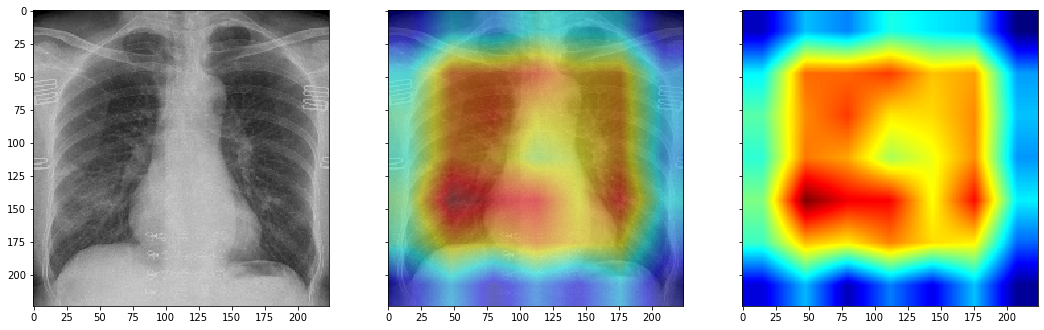

In [17]:
predictions = mnmodel.predict(np.array([img]))
c = np.argmax(predictions)
label = list(train_it.class_indices.keys())[c]
print('class', c, '=>' , label, '- {:.2f}%'.format(predictions[0, c]*100))


explainer = GradCAM()

# visualize GradCAM outputs in Block 1
grid1, conv_outputs1, guided_grads1 = explainer.explain(([img], None), mnmodel, 0, 'Conv_1_bn')

maps = explainer.generate_ponderated_output(conv_outputs1, guided_grads1)

heatmap = maps[0].numpy()
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())
heatmap = cv2.applyColorMap(
        cv2.cvtColor((heatmap * 255).astype("uint8"), cv2.COLOR_GRAY2BGR), cv2.COLORMAP_JET
    )

heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
hmonim_rgb = 0.5*img.astype(np.float) + 0.5*heatmap.astype(np.float)/255.
# plt.imshow(heatmap)
# plt.figure()
# plt.imshow(hmonim_rgb)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18, 18))
ax1.imshow(img)
ax2.imshow(hmonim_rgb)
ax3.imshow(heatmap)

plt.savefig('./data/test1/val/covid/' + name + '_{:.2f}_hm.png'.format(predictions[0, c]*100))
